# SHUBHAM SHARMA
## IIT BOMBAY
This code is an improvisation of what we did in the 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#For preparing the dataset
import h5py
import numpy as np
#For making the VGG model
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
path='gdrive/My Drive/data_phase1/'
with h5py.File(path+"full_dataset_vectors.h5", "r") as hf:   
    ls=list(hf.keys())
    print('List of datasets in this file : \n',ls)
with h5py.File(path+"full_dataset_vectors.h5", "r") as hf:   
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]    
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:]
    
X_train=X_train.reshape(10000,1, 16,16,16)
X_test=X_test.reshape(2000,1, 16,16,16)
print('The shape of X_train is :', X_train.shape)
print('The shape of y_train is :', y_train.shape)
print('The shape of X_test is :', X_test.shape)
print('The shape of y_test is :', y_test.shape)

List of datasets in this file : 
 ['X_test', 'X_train', 'y_test', 'y_train']
The shape of X_train is : (10000, 1, 16, 16, 16)
The shape of y_train is : (10000,)
The shape of X_test is : (2000, 1, 16, 16, 16)
The shape of y_test is : (2000,)


Text(0.5, 0.98, 'Center slices for image')

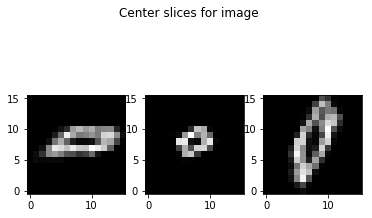

In [0]:
x=X_train[7,0]
def show_slices(slices):
# Function to display row of image slices
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")
    
slice_0 = x[8, :, :]
slice_1 = x[:, 8, :]
slice_2 = x[:, :, 8]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for image")

In [0]:
print('The max of X_train is :',np.max(X_train))
print('The min of X_train is :',np.min(X_train))
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

The max of X_train is : 1.0
The min of X_train is : 0.0


In [0]:
#CHecking the number of GPU and then setting the GPU id
print(torch.cuda.current_device())#To know thw current active device
print(torch.cuda.get_device_capability())#the major and minor cuda capability of the device
device = torch.device('cuda')

0
(3, 7)


In [0]:
#Defining the variables
#Let the input layer is of depth 2 
inp=8
#No of elements in the first fully connected layer
fully_connected_1=20
#No of elements in the output layer
n_labels=10
# Defining probabilities for dropouts
prob=0.2

#for flattening
def find_size(y):
  s=y.size()
  mul=s[1]*s[2]*s[3]*s[4]
  return mul

###################################################################################
class Net(nn.Module):
  
  def __init__(self):
    super(Net,self).__init__()
    
    
    #For first layer input
    self.conv1a=nn.Conv3d(in_channels=1, out_channels=inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.conv1b=nn.Conv3d(in_channels=inp, out_channels=inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.BN1=nn.BatchNorm3d(inp)
    
    #For second layer input
    self.conv2a=nn.Conv3d(in_channels=inp, out_channels=2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.conv2b=nn.Conv3d(in_channels=2*inp, out_channels=2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.BN2=nn.BatchNorm3d(2*inp)

    #For third layer input
    self.conv3a=nn.Conv3d(in_channels=2*inp, out_channels=2*2*inp, kernel_size=(3,3,3), stride=1, padding=1)
#     self.conv3a=nn.Conv3d(in_channels=2*inp, out_channels=2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.conv3b=nn.Conv3d(in_channels=2*2*inp, out_channels=2*2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.BN3=nn.BatchNorm3d(2*2*inp)

    #For forth layer input
    self.conv4a=nn.Conv3d(in_channels=2*2*inp, out_channels=2*2*2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.conv4b=nn.Conv3d(in_channels=2*2*2*inp, out_channels=2*2*2*inp, kernel_size=(3,3,3), stride=1, padding=1)
    self.BN4=nn.BatchNorm3d(2*2*2*inp)
    
    #Max pool layer
    self.max_pool=nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    #Now thw fully connected layers
    #chane value as per the result of flat
    self.fc1 = nn.Linear(2048,fully_connected_1)
    self.fc2 = nn.Linear(fully_connected_1,n_labels)
    
    #Defining activations
    self.relu = nn.ReLU()
    
    
    #Defining dropoutsA
    self.dout = nn.Dropout(p=prob)
    
    ####################################################################
  def forward(self,x):
    y=self.conv1a(x)
    y=self.BN1(y)
    y=self.relu(y)
    y=self.conv1b(y)
    y=self.BN1(y)
    y=self.relu(y)
    y=self.max_pool(y)
    ##
    y=self.conv2a(y)
    y=self.BN2(y)
    y=self.relu(y)
    y=self.conv2b(y)
    y=self.BN2(y)
    y=self.relu(y)
    y=self.max_pool(y)
#     ##
    y=self.conv3a(y)
    y=self.BN3(y)
    y=self.relu(y)
#     y=self.conv3b(y)
#     y=self.BN3(y)
#     y=self.relu(y)
#     y=self.max_pool(y)
    ##
#     y=self.conv4a(y)
#     y=self.BN4(y)
#     y=self.relu(y)
#     y=self.conv4b(y)
#     y=self.BN4(y)
#     y=self.relu(y)
#     y=self.max_pool(y)
  
  
    flat= find_size(y)
#     print('The number of nodes in the falttened output',flat)
    # Fully Connected Layers
    y=y.view(-1,flat)
    y=self.fc1(y)
    y=self.relu(y)
    y=self.dout(y)
    y=self.fc2(y)
    return y

      
      
##########################################################################
model = Net().to(device)#not necessary to add to device
summary(model, input_size=(1, 16, 16, 16))
    
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 16, 16, 16]             224
       BatchNorm3d-2        [-1, 8, 16, 16, 16]              16
              ReLU-3        [-1, 8, 16, 16, 16]               0
            Conv3d-4        [-1, 8, 16, 16, 16]           1,736
       BatchNorm3d-5        [-1, 8, 16, 16, 16]              16
              ReLU-6        [-1, 8, 16, 16, 16]               0
         MaxPool3d-7           [-1, 8, 8, 8, 8]               0
            Conv3d-8          [-1, 16, 8, 8, 8]           3,472
       BatchNorm3d-9          [-1, 16, 8, 8, 8]              32
             ReLU-10          [-1, 16, 8, 8, 8]               0
           Conv3d-11          [-1, 16, 8, 8, 8]           6,928
      BatchNorm3d-12          [-1, 16, 8, 8, 8]              32
             ReLU-13          [-1, 16, 8, 8, 8]               0
        MaxPool3d-14          [-1, 16, 

In [0]:
lr=1e-6
num_of_epochs=200
batch_size=64
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()#NO NEED TO BE USING SOFTMAX WHEN USING Crioss Entropy loss
optimizer = optim.Adam(model.parameters(), lr=lr)  

trainset = torch.utils.data.TensorDataset(X_train,y_train)# create your datset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valset = torch.utils.data.TensorDataset(X_test,y_test)# create your datset
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True)

#Training the model
total_step = len(trainloader)
for epochs in range(num_of_epochs):
  for i, (images, labels) in enumerate(trainloader):  
    #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
    images = images.to(device)
    images= images.float()
    labels = labels.to(device)  
    
    #Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Backpropagation and then optimization
    optimizer.zero_grad()#Initially setting the gradient values to zero so backward() can find the gradient
    loss.backward()#backpropagate and then optimize
    optimizer.step()
    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
             .format(epochs+1, num_of_epochs, i+1, total_step, loss.item()))
      
      
################################
#For testing
#For Testing
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  correct=0
  total=0
  for images, labels in valloader:
    images=images.to(device)
    images= images.float()
    labels=labels.to(device)
    outputs= model(images)
    #outputs.data is the output of softmax layer
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

  



Epoch [1/200], Step [100/157], Loss: 0.2578
Epoch [2/200], Step [100/157], Loss: 0.3425
Epoch [3/200], Step [100/157], Loss: 0.3893
Epoch [4/200], Step [100/157], Loss: 0.3673
Epoch [5/200], Step [100/157], Loss: 0.3796
Epoch [6/200], Step [100/157], Loss: 0.3424
Epoch [7/200], Step [100/157], Loss: 0.2454
Epoch [8/200], Step [100/157], Loss: 0.4086
Epoch [9/200], Step [100/157], Loss: 0.3921
Epoch [10/200], Step [100/157], Loss: 0.3090
Epoch [11/200], Step [100/157], Loss: 0.3559
Epoch [12/200], Step [100/157], Loss: 0.5155
Epoch [13/200], Step [100/157], Loss: 0.4041
Epoch [14/200], Step [100/157], Loss: 0.2244
Epoch [15/200], Step [100/157], Loss: 0.2963
Epoch [16/200], Step [100/157], Loss: 0.3966
Epoch [17/200], Step [100/157], Loss: 0.4325
Epoch [18/200], Step [100/157], Loss: 0.4752


KeyboardInterrupt: ignored

In [0]:
################################
#For testing
#For Testing
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  correct=0
  total=0
  for images, labels in valloader:
    images=images.to(device)
    images= images.float()
    labels=labels.to(device)
    outputs= model(images)
    #outputs.data is the output of softmax layer
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 60.35 %
